In [2]:
#NOTE: using an older version of Optimizer class which contains the loading and saving capabilities for making the following plots

In [3]:
from custom_gates import *
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from itertools import cycle
from weylchamber import c1c2c3, g1g2g3
from qiskit.circuit.library.standard_gates import *
from qiskit.quantum_info import Operator, random_unitary, random_clifford
import scipy.optimize as opt
import hashlib
from circuit_template import TemplateCircuit

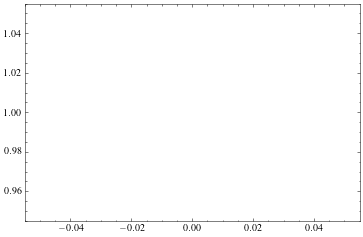

In [4]:
import matplotlib.pyplot as plt
plt.style.use(["science", "ieee"])
plt.plot([0,0], [1,1]);
plt.style.use(["science", "ieee"])
#I'm not sure why but the styles don't get updated until after running twice, so monkey fix like this??

In [5]:
import logging

logger = logging.getLogger()
logger.setLevel(logging.INFO)


In [6]:
import h5py

def h5py_load(filekey, *args):
    filename = f"data/{filekey}.h5"
    results = {}
    try:
        with h5py.File(filename, "r") as h5f:
            for arg in args:
                results[arg] = h5f[arg][:]
        return results
    except FileNotFoundError:
        logging.debug(f"Failed to load {filename}")
        return None


def h5py_save(filekey, **kwargs):
    filename = f"data/{filekey}.h5"
    with h5py.File(filename, "a") as h5f:
        for key, value in kwargs.items():
            try:
                del h5f[key]
            except Exception:
                pass
            h5f.create_dataset(key, data=value)
    logging.debug(f"Successfully saved to {filename}")


# we need some helper method to fix ragged arrays from training loss data
# previously, I was padding values with -1, so data points could easily be deleted later,
# I think it makes more sense to pad with the last remaining value, since training converges it just sits at that value
#TODO: could rewrite for so functional handles deepcopying rather than caller like as is currently
def rag_to_pad(arr):
    max_len = max(len(arr[i]) for i in range(len(arr)))
    for i in range(len(arr)):
        temp_len = len(arr[i])
        for j in range(max_len):
            if j >= temp_len:
                if j == 0:
                    raise ValueError("cant extend blank row")
                arr[i].append(arr[i][j-1])
                #arr[i].append(-1)
    return np.array(arr)

#rewrite convert to ragged array by detecting when row is being extended
def pad_to_rag(arr):
    arr = arr.tolist()
    for i in range(len(arr)):
        for j in range(len(arr[i])):
            #if arr[i][j] == -1:
            if arr[i][j] == arr[i][j-1]:
                arr[i] = arr[i][0:j]
                break
    return arr

#test
# arr = [[1, 2, 3, 4], [1, 2], [1, 2, 3]]
# arr = rag_to_pad(arr)
# print(arr)
# arr = pad_to_rag(arr)
# print(arr)

In [7]:
class TemplateOptimizer:
    def __init__(
        self,
        template,
        objective_function_name="basic",
        unitary_sample_function="Haar",
        n_samples=1,
        template_iter_range=range(2, 4),
        no_save=True
    ):
        """Args:
        template: TemplateCircuit object
        objective_function_name: "basic" or "square"
        unitary_sample_function: "Haar" or "Clifford for random sampling, "SWAP", "CNOT", "iSWAP" for single gates
        n_samples: the number of times to sample a gate and minimize template on
        template_iter_range: a range() object that whos values are passed to template.build()
        """
        self.template = template
        self.sampler = self._sample_function(unitary_sample_function)
        self.n_samples = n_samples
        self.obj_f_name = objective_function_name
        self.template_iter_range = template_iter_range
        self.filekey = hashlib.sha1(
            (
                self.template.hash
                + str(objective_function_name)
                + str(unitary_sample_function)
                + str(template_iter_range)
            ).encode()
        ).hexdigest()
        self.plot_title = None
        self.training_loss = []
        self.training_reps = []
        self.no_save=no_save

    def run(self, override_saved=False):
        # first attempt to load n_samples from data
        offset = 0
        results = None
        if not self.no_save and not override_saved:
            results = h5py_load(self.filekey, "training_loss", "training_reps")
            if results is not None:
                self.training_loss = pad_to_rag(results["training_loss"])
                self.training_reps = results["training_reps"].tolist()
                offset = len(self.training_loss)
                logging.info(f"Loaded {offset} samples")

        # run minimize on the remaining samples
        # use try finally, so if end early stills writes back what it has thus far
        # XXX I'm not sure this actually works, dont rely on it
        best_result, best_Xk, best_cycles = None, None, None
        try:
            for i in range(offset, self.n_samples):
                logging.info(f"Starting sample iter {i}")
                self.training_loss.append([])
                target_unitary = self.sampler()
                obj = self._objective_function(self.obj_f_name, target_unitary)
                best_result, best_Xk, best_cycles = self.minimize(
                    obj=obj, iter=i, t_range=self.template_iter_range
                )
        finally:
            # finally, save again
            if self.n_samples > offset and not self.no_save:
                # use list comprehension to pass by value (deepcopy)
                h5py_save(
                    self.filekey,
                    training_loss=rag_to_pad([row[:] for row in self.training_loss]),
                    training_reps=self.training_reps,
                )
        return best_result, best_Xk, best_cycles

    def minimize(self, obj, iter, t_range):
        # NOTE: potential for speedup?
        # you can calculate ahead of time the number of repetitions needed using traces??

        # callback used to save current loss after each iteration
        def callbackF(xk):
            loss = obj(xk)
            temp_training_loss.append(loss)

        best_result = None
        best_Xk = None
        best_cycles = -1

        # each t creates fresh template with new repetition param
        for t in t_range:
            logging.info(f"Starting cycle length {t}")
            temp_training_loss = []
            self.template.build(n_repetitions=t)

            starting_attempts = 5
            for _ in range(starting_attempts):

                if self.obj_f_name == "makhlin":
                    result = opt.basinhopping(func=obj, x0=self.template.initial_guess(), niter=3, minimizer_kwargs={"callback":callbackF})

                else: #self.obj_f_name == "basic" or self.obj_f_name == "square"
                    result = opt.minimize(
                        fun=obj,
                        method='BFGS',#'nelder-mead',
                        x0=self.template.initial_guess(),
                        callback=callbackF,
                        options={"maxiter": 200},
                    )
                    # result = opt.minimize(
                    #     fun=obj,
                    #     method='BFGS',
                    #     x0=result.x,
                    #     callback=callbackF,
                    #     options={"maxiter": 1000},
                    # )
                

                # result is good, update temp vars
                if best_result is None or result.fun < best_result:
                    best_result = result.fun
                    best_Xk = result.x
                    best_cycles = self.template.cycles
                    self.training_loss[iter] = temp_training_loss
                
                #break over starting attempts
                if best_result < 1e-9:
                    break
            
            #break over template extensions
            # already good enough, save time by stopping here
            if best_result < 1e-9:
                logging.info(f"Break on cycle {t}")
                break

        logging.info(f"loss= {best_result}")
        self.training_reps.append(best_cycles)
        return best_result, best_Xk, best_cycles

    def _sample_function(self, name):
        if name == "I":
            return lambda: np.eye(N=2 ** self.template.n_qubits)
        if name == "CParitySwap":
            return lambda: CParitySwap()
        if name == "CiSWAP":
            return lambda: CiSwap()
        if name == "CCiX":
            return lambda: CCiXGate()
        if name == "Peres":
            return lambda: Peres()
        if name == "Toffoli":
            return lambda: CCXGate()
        if name == "CSWAP":
            return lambda: CSwapGate()
        if name == "RCCXGate":
            return lambda: RCCXGate()
        if name == "SWAP":
            return lambda: SwapGate()
        if name == "CNOT":
            return lambda: CXGate()
        if name == "iSWAP":
            return lambda: iSwapGate()
        if name == "Haar":
            return lambda: random_unitary(dims=2 ** self.template.n_qubits).data
        if name == "Haar-2":
            logging.warning(f"Only works for \sqrt[2]iSwap")
            return lambda: Operator(self._haar_ground_truth(2)).data
        if name == "Haar-3":
            logging.warning(f"Only works for \sqrt[2]iSwap")
            return lambda: Operator(self._haar_ground_truth(3)).data
        if name == "Clifford":
            return lambda: Operator(
                random_clifford(num_qubits=self.template.n_qubits)
            ).data
        else:
            raise ValueError(f"No sample function named {name}")

    def _haar_ground_truth(self, haar_exact=2):
        """When using sqrt[2] iswap, we might want to do a haar sample where we know ahead of time if it will take 2 or 3 uses
        this is used for establishing the effectiveness of our optimizer, but won't work for any other basis gate"""
        from qiskit.transpiler.passmanager import PassManager
        from qiskit.transpiler.passes import CountOps
        from deprecate.weyl_exact import RootiSwapWeylDecomposition
        pm0 = PassManager()
        pm0.append(RootiSwapWeylDecomposition(basis_gate=RiSwapGate(0.5)))
        pm0.append(CountOps())
        logger.setLevel(logging.CRITICAL)
        while True:
            qc = QuantumCircuit(2)
            qc.append(random_unitary(dims=4), [0,1])
            pm0.run(qc)
            if haar_exact == pm0.property_set['count_ops']['riswap']:
                logger.setLevel(logging.INFO)
                return qc
        

    def _objective_function(self, name, target):
        if name == "basic":
            h = np.matrix(target).getH()
            return (
                lambda X: 1
                - np.abs(
                    np.trace(np.matmul(h, self.template.eval(X)))
                )
                / np.array(target).shape[0]
            )
        if name == "square":
            h = np.matrix(target).getH()
            return lambda X: 1 - (
                np.abs(np.trace(np.matmul(h, self.template.eval(X)))) ** 2
                + np.array(target).shape[0]
            ) / (np.array(target).shape[0] * (np.array(target).shape[0] + 1))

        if name == "basic-reduced":
            #version that eliminates exterior 1Q gates by converting to can basis
            #need to also convert the template to can basis for similarity
            can_target_h = np.matrix(weylchamber.canonical_gate(*c1c2c3(target))).getH()
            return (
                lambda X: 1
                - np.abs(
                    np.trace(np.matmul(can_target_h, np.matrix(weylchamber.canonical_gate(*c1c2c3(self.template.eval(X))))))
                )
                / np.array(target).shape[0]
            )
        if name == "square-reduced":
            can_target_h = np.matrix(weylchamber.canonical_gate(*c1c2c3(target))).getH()
            return lambda X: 1 - (
                np.abs(np.trace(np.matmul(can_target_h, self.template.eval(X)))) ** 2
                + np.array(target).shape[0]
            ) / (np.array(target).shape[0] * (np.array(target).shape[0] + 1))
        
        if name == "square-reduced-bell":
            from weylchamber import bell_basis
            bell_h = np.matrix(bell_basis(target)).getH()
            return lambda X: 1- np.abs(np.trace(np.matmul(bell_h, bell_basis(self.template.eval(X)))))/ np.array(target).shape[0]

        if name == "weyl":
            if self.template.n_qubits != 2:
                raise ValueError("Weyl chamber only for 2Q gates")
            c = c1c2c3(target)
            return lambda X: np.linalg.norm(
                np.array(c) - np.array(c1c2c3(self.template.eval(X)))
            )
        if name == "makhlin":
            if self.template.n_qubits != 2:
                raise ValueError("Weyl chamber on for 2Q gates")
            g = g1g2g3(target)
            return lambda X: np.linalg.norm(
                    np.array(g)- np.array(g1g2g3(self.template.eval(X)))
                )
        if name == "functional":
            from weylchamber import J_T_LI
            return lambda X: J_T_LI(target, self.template.eval(X))
        else:
            raise ValueError(f"No objective function named {name}")

    @staticmethod
    def plot(fig_title, *optimizers):
        #NOTE: previous version used different colors to signal different template lengths
        #now I am changing so different colors correspond to different Haar samples, assuming now template size is always fixed
        c = ["black", "tab:red", "tab:blue", "tab:orange", "tab:green"]

        # each optimizer is its own column subplot
        fig, axs = plt.subplots(1, len(optimizers), sharey=True, squeeze=False)
        for ax_index, optimizer in enumerate(optimizers):

            # each sample gets plotted as a faint line
            for i in range(optimizer.n_samples):
                axs[0][ax_index].plot(
                    optimizer.training_loss[i],
                    alpha=0.2,
                    color=c[i %len(c)],
                    #color=c[optimizer.training_reps[i] % len(c)],
                    linestyle="-",
                )

            # plot horizontal line to show average of final converged value
            converged_averaged = np.mean([min(el) for el in optimizer.training_loss])
            axs[0][ax_index].axhline(
                converged_averaged, alpha=0.8, color="tab:gray", linestyle="--"
            )
            axs[0][ax_index].text(
                0.5,
                converged_averaged * 1.01,
                "Avg: " + "{:.2E}".format(converged_averaged),
                {"size": 5},
            )

            # custom average for ragged array
            # XXX there must be a smart way to do this I couldn't think of it at the time I wrote this :(
            # for reps in set(optimizer.training_reps):
            #     # filter training data for each rep value
            #     temp = [
            #         optimizer.training_loss[i]
            #         for i in range(len(optimizer.training_reps))
            #         if optimizer.training_reps[i] == reps
            #     ]

            #     # construct average over points where data exists
            #     # uses row-col outer-inner loop over points, increments counter k for norming
            #     temp_average = []
            #     for i in range(max([len(el) for el in temp])):
            #         temp_average.append(0)
            #         k = 0
            #         for j in range(len(temp)):
            #             if i < len(temp[j]):
            #                 temp_average[i] += temp[j][i]
            #                 k += 1
            #         temp_average[i] /= k

            #     # plot average with full color
            #     axs[0][ax_index].plot(
            #         temp_average,
            #         color='black',
            #         #color=c[reps % len(c)],
            #         label=f"L{reps}",
            #         linestyle="dashed",
            #     )

            axs[0][ax_index].set_yscale("log")
            axs[0][ax_index].set_xlabel("Training Steps")
            axs[0][ax_index].set_title(f"{optimizer.plot_title}")
            axs[0][ax_index].legend()

        fig.suptitle(f"{fig_title}, (N={optimizers[0].n_samples})", y=0.92)
        axs[0][0].set_ylabel("Training Loss")
        fig.tight_layout()
        fig.show()


# test objective function
# n = TemplateCircuit(n_qubits=3)
# a = TemplateOptimizer(n)._objective_function(name="nuop", target=Operator(CCXGate()).data)
# a(Operator(CCXGate()).data)


In [8]:
# template = TemplateCircuit()
# optimizer = TemplateOptimizer(template, n_samples=1, unitary_sample_function="I", template_iter_range=[2])
# optimizer.run(override_saved=True)
# optimizer.plot_title = "Basic Loss"

# optimizer3 = TemplateOptimizer(template, n_samples=1, unitary_sample_function="I", template_iter_range=[3])
# optimizer3.run(override_saved=True)
# optimizer3.plot_title = "Basic Loss"


In [9]:
N=5

In [10]:
template = TemplateCircuit()
optimizer = TemplateOptimizer(template, n_samples=N, unitary_sample_function="Haar-2", template_iter_range=[2], no_save=True)
optimizer.run(override_saved=True)
optimizer.plot_title = "Basic Loss"

INFO:root:Starting sample iter 0
INFO:root:Starting cycle length 2
INFO:root:Break on cycle 2
INFO:root:loss= 1.8092116693679827e-10
INFO:root:Starting sample iter 1
INFO:root:Starting cycle length 2
INFO:root:Break on cycle 2
INFO:root:loss= 1.518015713131149e-10
INFO:root:Starting sample iter 2
INFO:root:Starting cycle length 2
INFO:root:Break on cycle 2
INFO:root:loss= 9.449606652722764e-10
INFO:root:Starting sample iter 3
INFO:root:Starting cycle length 2
INFO:root:Break on cycle 2
INFO:root:loss= 2.0291834879060389e-10
INFO:root:Starting sample iter 4
INFO:root:Starting cycle length 2
INFO:root:Break on cycle 2
INFO:root:loss= 8.38673686054392e-10


In [39]:
template = TemplateCircuit(no_exterior_1q=True)
optimizer2 = TemplateOptimizer(template, n_samples=N, unitary_sample_function="Haar-2", objective_function_name="makhlin", template_iter_range=[2], no_save=True)
optimizer2.run(override_saved=True)
optimizer2.plot_title = "Makhlin-Reduced Loss"

INFO:root:Starting sample iter 0
INFO:root:Starting cycle length 2
INFO:root:loss= 0.0075429227740313
INFO:root:Starting sample iter 1
INFO:root:Starting cycle length 2
INFO:root:loss= 0.013581201380338177
INFO:root:Starting sample iter 2
INFO:root:Starting cycle length 2
INFO:root:loss= 0.016769187920364543
INFO:root:Starting sample iter 3
INFO:root:Starting cycle length 2
INFO:root:loss= 0.013800060593015525
INFO:root:Starting sample iter 4
INFO:root:Starting cycle length 2
INFO:root:loss= 0.008013972352217095


In [41]:
template = TemplateCircuit(no_exterior_1q=False)
optimizer10 = TemplateOptimizer(template, n_samples=N, unitary_sample_function="Haar-2", objective_function_name="makhlin", template_iter_range=[2], no_save=True)
optimizer10.run(override_saved=True)
optimizer10.plot_title = "Makhlin Loss"

INFO:root:Starting sample iter 0
INFO:root:Starting cycle length 2
INFO:root:loss= 0.036073944165441615
INFO:root:Starting sample iter 1
INFO:root:Starting cycle length 2
INFO:root:loss= 0.013307776307651857
INFO:root:Starting sample iter 2
INFO:root:Starting cycle length 2
INFO:root:loss= 0.012653371605753937
INFO:root:Starting sample iter 3
INFO:root:Starting cycle length 2
INFO:root:loss= 0.0044240546022285936
INFO:root:Starting sample iter 4
INFO:root:Starting cycle length 2
INFO:root:loss= 0.0012851674644963605


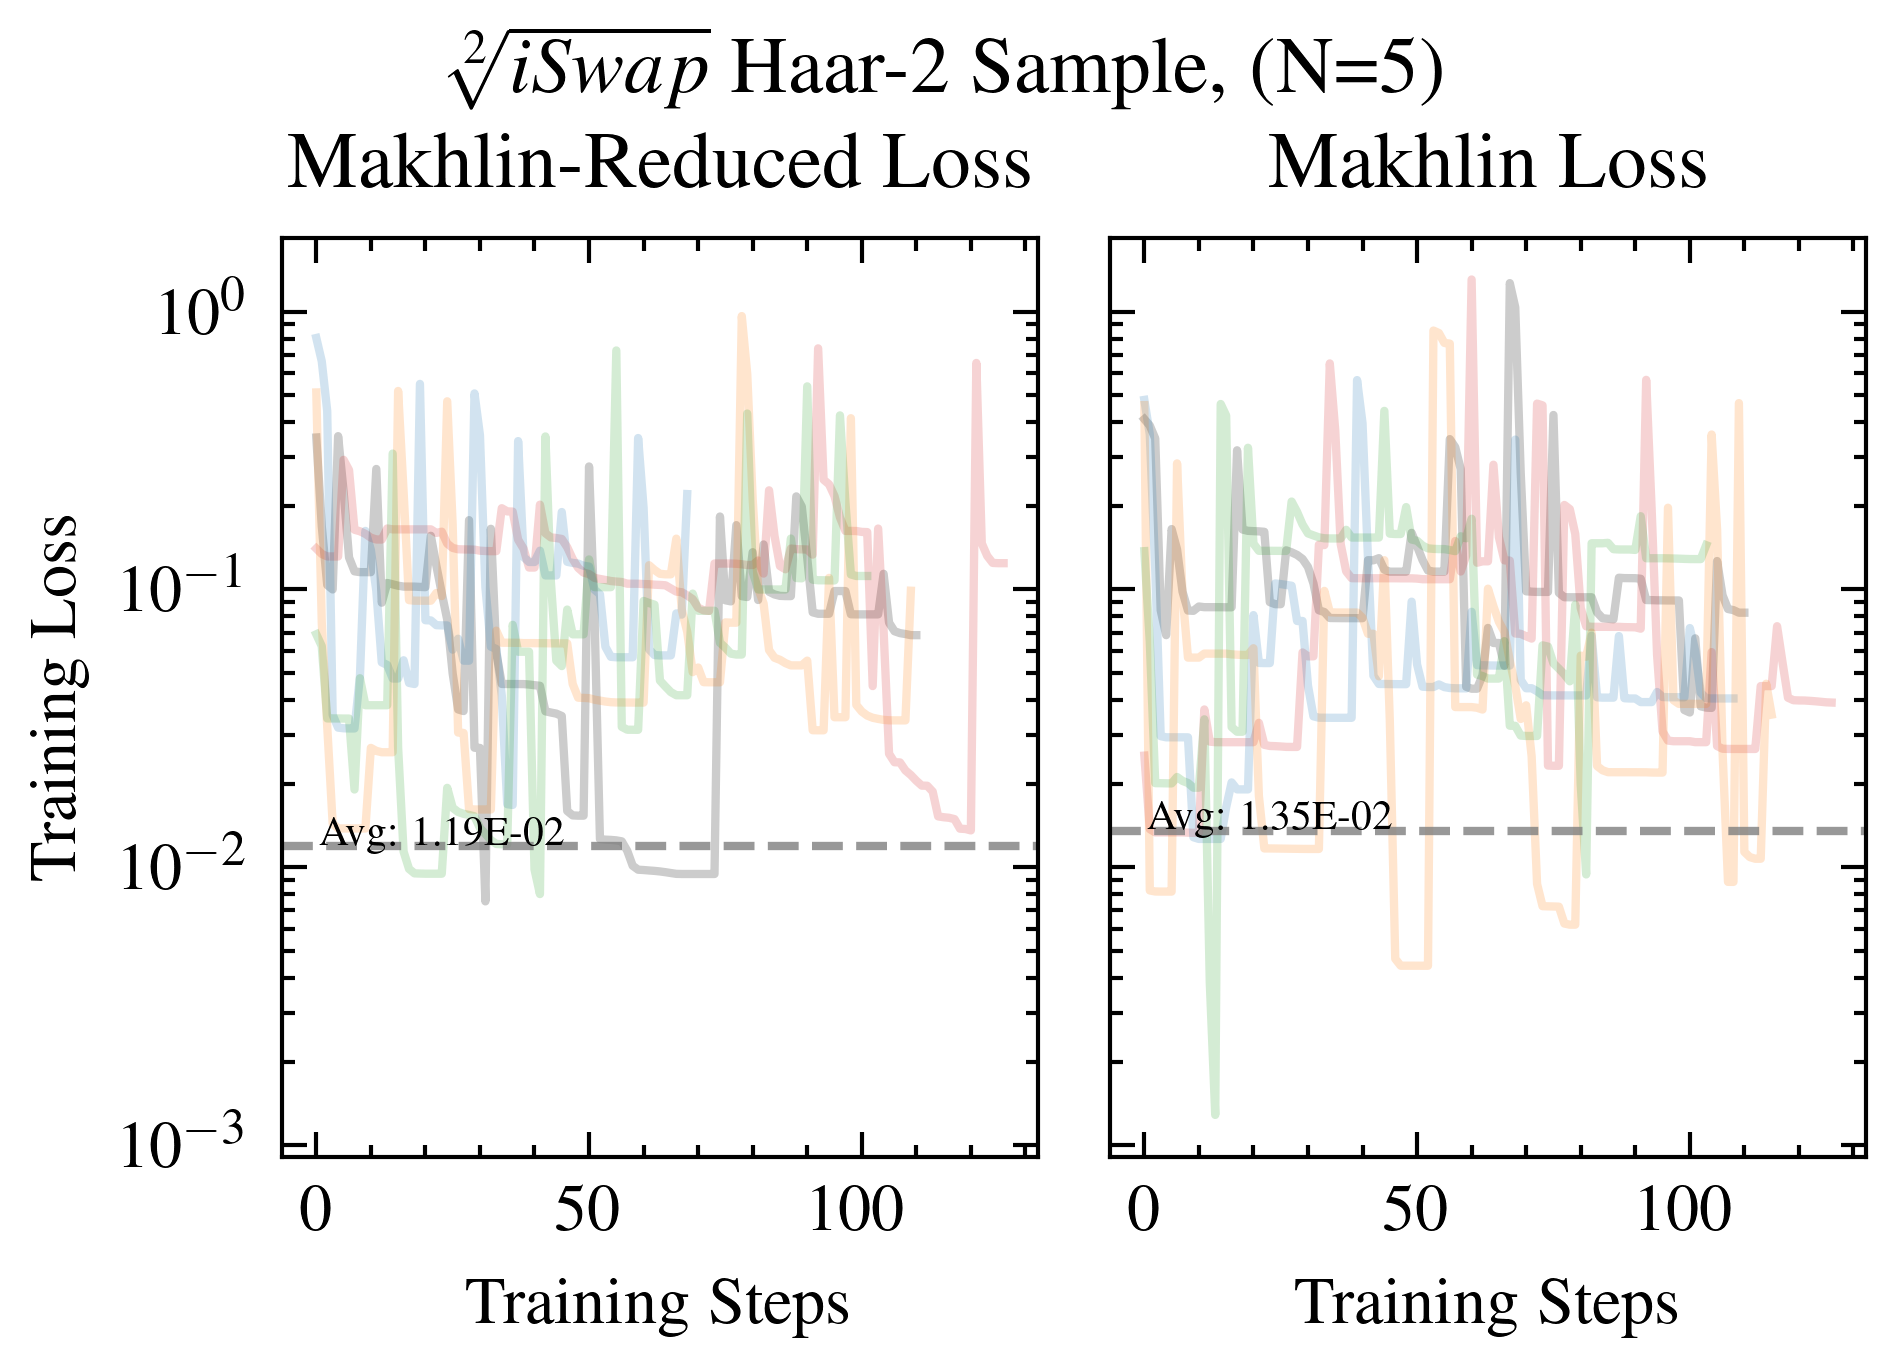

In [42]:
TemplateOptimizer.plot(f"{RiSwapGate.latex_string([1/2])} Haar-2 Sample", optimizer2, optimizer10)#optimizer3, optimizer2, optimizer4, optimizer5)

In [12]:
template = TemplateCircuit()
optimizer3 = TemplateOptimizer(template, n_samples=N, unitary_sample_function="Haar-2", objective_function_name="square", template_iter_range=[2], no_save=True)
optimizer3.run(override_saved=True)
optimizer3.plot_title = "Square Loss"

INFO:root:Starting sample iter 0
INFO:root:Starting cycle length 2
INFO:root:Break on cycle 2
INFO:root:loss= 5.939192471160482e-10
INFO:root:Starting sample iter 1
INFO:root:Starting cycle length 2
INFO:root:Break on cycle 2
INFO:root:loss= 9.416056823141616e-11
INFO:root:Starting sample iter 2
INFO:root:Starting cycle length 2
INFO:root:Break on cycle 2
INFO:root:loss= 2.4419066768643916e-10
INFO:root:Starting sample iter 3
INFO:root:Starting cycle length 2
INFO:root:Break on cycle 2
INFO:root:loss= 4.9767634457964505e-11
INFO:root:Starting sample iter 4
INFO:root:Starting cycle length 2
INFO:root:Break on cycle 2
INFO:root:loss= 2.6766144856082974e-10


In [43]:
template = TemplateCircuit(no_exterior_1q=True)
optimizer4 = TemplateOptimizer(template, n_samples=N, unitary_sample_function="Haar-2", objective_function_name="basic-reduced", template_iter_range=[2], no_save=True)
optimizer4.run(override_saved=True)
optimizer4.plot_title = "Basic-Reduced (T) Loss"

INFO:root:Starting sample iter 0
INFO:root:Starting cycle length 2
INFO:root:loss= 0.06750442744945906
INFO:root:Starting sample iter 1
INFO:root:Starting cycle length 2
INFO:root:loss= 0.17985808933471448
INFO:root:Starting sample iter 2
INFO:root:Starting cycle length 2
INFO:root:loss= 0.06757580914381422
INFO:root:Starting sample iter 3
INFO:root:Starting cycle length 2
INFO:root:loss= 0.12634223051153393
INFO:root:Starting sample iter 4
INFO:root:Starting cycle length 2
INFO:root:loss= 0.1230520885418317


In [44]:
template = TemplateCircuit(no_exterior_1q=False)
optimizer4 = TemplateOptimizer(template, n_samples=N, unitary_sample_function="Haar-2", objective_function_name="basic-reduced", template_iter_range=[2], no_save=True)
optimizer4.run(override_saved=True)
optimizer4.plot_title = "Basic-Reduced (F) Loss"

INFO:root:Starting sample iter 0
INFO:root:Starting cycle length 2


In [ ]:
TemplateOptimizer.plot(f"{RiSwapGate.latex_string([1/2])} Haar-2 Sample", optimizer2, optimizer4)#optimizer3, optimizer2, optimizer4, optimizer5)

In [14]:
template = TemplateCircuit(no_exterior_1q=True)
optimizer5 = TemplateOptimizer(template, n_samples=N, unitary_sample_function="Haar-2", objective_function_name="square-reduced", template_iter_range=[2], no_save=True)
optimizer5.run(override_saved=True)
optimizer5.plot_title = "Square-Reduced Loss"

INFO:root:Starting sample iter 0
INFO:root:Starting cycle length 2
INFO:root:loss= 0.1113700975848062
INFO:root:Starting sample iter 1
INFO:root:Starting cycle length 2
INFO:root:loss= 0.1310686506834685
INFO:root:Starting sample iter 2
INFO:root:Starting cycle length 2
INFO:root:loss= 0.09203099242528268
INFO:root:Starting sample iter 3
INFO:root:Starting cycle length 2
INFO:root:loss= 0.07123255887607383
INFO:root:Starting sample iter 4
INFO:root:Starting cycle length 2
INFO:root:loss= 0.22057517081375388


In [34]:
template = TemplateCircuit(no_exterior_1q=1)
template.build(2)
template.circuit.draw()

┌─────────────────────────┐┌─────────────┐┌─────────────────────────┐
q_0: ┤0                        ├┤ U(P0,P1,P2) ├┤0                        ├
     │  $\sqrt[2]{iSwap}$(0.5) │├─────────────┤│  $\sqrt[2]{iSwap}$(0.5) │
q_1: ┤1                        ├┤ U(P3,P4,P5) ├┤1                        ├
     └─────────────────────────┘└─────────────┘└─────────────────────────┘

In [25]:
template = TemplateCircuit(no_exterior_1q=False)
optimizer7 = TemplateOptimizer(template, n_samples=N, unitary_sample_function="Haar-2", objective_function_name="square-reduced-bell", template_iter_range=[2], no_save=True)
optimizer7.run(override_saved=True)
optimizer7.plot_title = "Square-Reduced-Bell Loss"

INFO:root:Starting sample iter 0
INFO:root:Starting cycle length 2
INFO:root:Break on cycle 2
INFO:root:loss= 4.733584635374655e-10
INFO:root:Starting sample iter 1
INFO:root:Starting cycle length 2
INFO:root:Break on cycle 2
INFO:root:loss= 1.6806511737854635e-10
INFO:root:Starting sample iter 2
INFO:root:Starting cycle length 2
INFO:root:Break on cycle 2
INFO:root:loss= 4.333496894659561e-10
INFO:root:Starting sample iter 3
INFO:root:Starting cycle length 2
INFO:root:Break on cycle 2
INFO:root:loss= 7.959123360379294e-10
INFO:root:Starting sample iter 4
INFO:root:Starting cycle length 2
INFO:root:Break on cycle 2
INFO:root:loss= 9.165905812125175e-10


In [16]:
template = TemplateCircuit(no_exterior_1q=False)
optimizer6 = TemplateOptimizer(template, n_samples=N, unitary_sample_function="Haar-2", objective_function_name="functional", template_iter_range=[2], no_save=True)
optimizer6.run(override_saved=True)
optimizer6.plot_title = "Functional Loss"

INFO:root:Starting sample iter 0
INFO:root:Starting cycle length 2
INFO:root:loss= 1.6488598633400004e-05
INFO:root:Starting sample iter 1
INFO:root:Starting cycle length 2
INFO:root:loss= 0.0031286577904100004
INFO:root:Starting sample iter 2
INFO:root:Starting cycle length 2
INFO:root:loss= 0.0011864521511192995
INFO:root:Starting sample iter 3
INFO:root:Starting cycle length 2
INFO:root:loss= 0.0047506226847579
INFO:root:Starting sample iter 4
INFO:root:Starting cycle length 2
INFO:root:loss= 0.004139571782217598


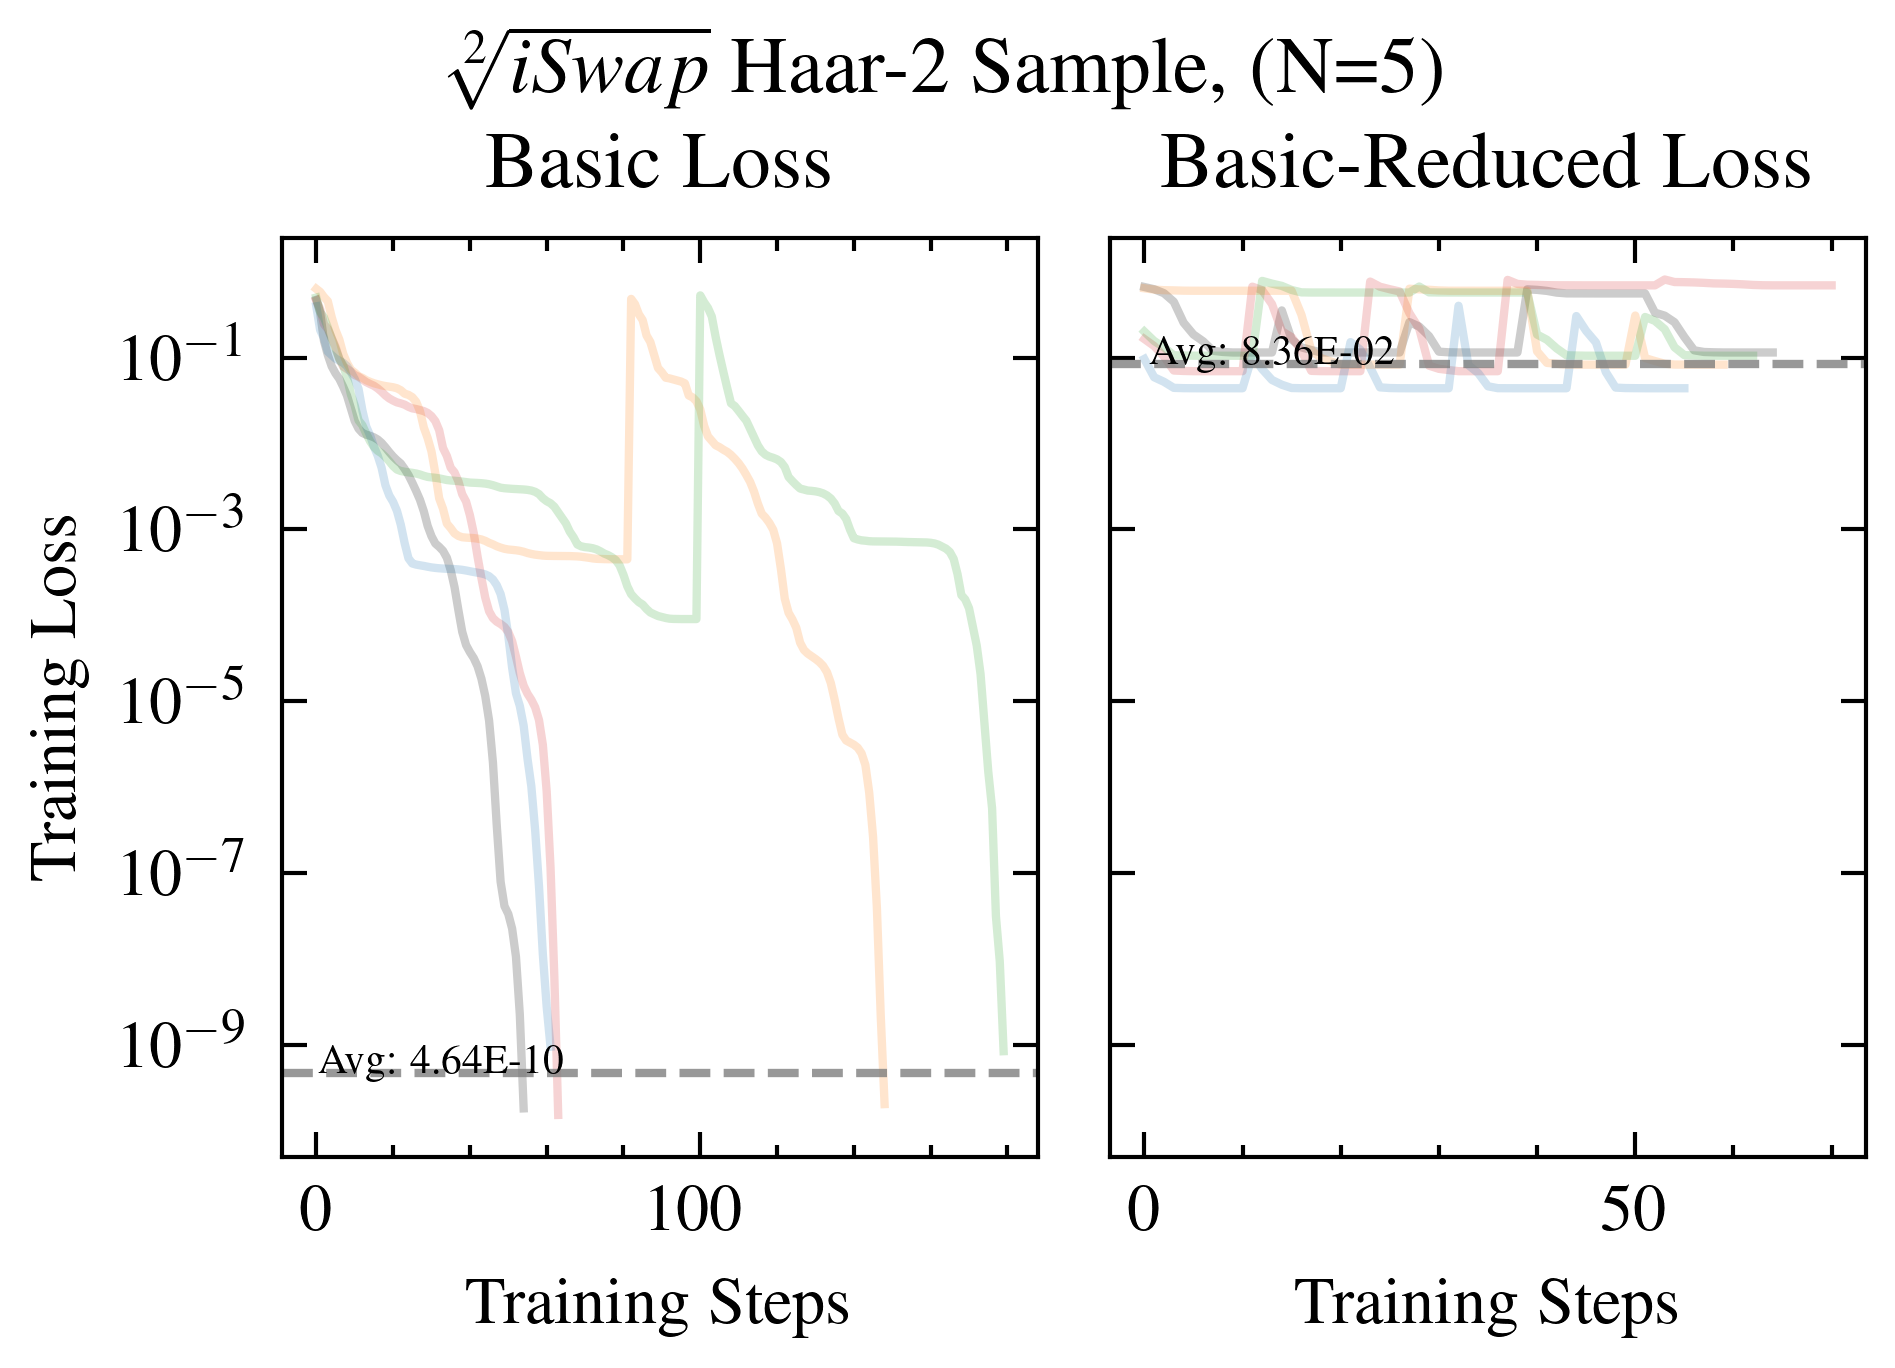

In [38]:
TemplateOptimizer.plot(f"{RiSwapGate.latex_string([1/2])} Haar-2 Sample", optimizer, optimizer4)#optimizer3, optimizer2, optimizer4, optimizer5)

In [18]:
# N = 1
# template = TemplateCircuit()
# optimizer = TemplateOptimizer(template, n_samples=N, objective_function_name="basic")
# optimizer.run(override_saved=True)
# optimizer.plot_title = "Basic"

# optimizer2 = TemplateOptimizer(template, n_samples=N, objective_function_name="square")
# optimizer2.run(override_saved=True)
# optimizer2.plot_title = "Square"
# TemplateOptimizer.plot(f"{RiSwapGate.latex_string(2)} var objectives, Haar sample", optimizer, optimizer2)
